# Imports
The file below must be ran before running any of the other files.

In [11]:
import torch
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from datasets import load_dataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold

from sklearn.inspection import permutation_importance


from tqdm import tqdm

In [12]:
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


# Loading Data

In [13]:
def load_and_prepare_data(iter_num, embed_type=None):

        if iter_num == 1 or iter_num == 2:
            train_dataset = 'lelexuanzz/WELFake_stylo_feats'
            eval_dataset = 'lelexuanzz/Gossipcop_Politifact_Test_Stylo'

        train_dataset = load_dataset(train_dataset)
        eval_dataset = load_dataset(eval_dataset)

        train_df = train_dataset["train"].to_pandas()
        eval_df = eval_dataset["train"].to_pandas()
        print(f"Dataset loaded. Shape: {train_df.shape}")

        print("Train columns:", train_df.columns.tolist())
        print("Eval columns:", eval_df.columns.tolist())

        exclude_patterns = ['title','text', 'label']
        label_column = "label"

        if iter_num == 1:
            feature_columns = [col for col in train_df.columns if not any(pattern in col.lower() for pattern in exclude_patterns)][:10]

            y = train_df[label_column]
            x = train_df[feature_columns]

            X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

            X_eval = eval_df[feature_columns].values
            Y_eval = eval_df[label_column].values

        elif iter_num == 2:
            feature_columns = [col for col in train_df.columns if not any(pattern in col.lower() for pattern in exclude_patterns)]

            y = train_df[label_column]
            x = train_df[feature_columns]

            X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

            X_eval = eval_df[feature_columns].values
            Y_eval = eval_df[label_column].values
            
        elif iter_num == 3:
            feature_columns = 'roberta_embedding'
            y = train_df[label_column]
            x = train_df[embed_type]
            X_eval = eval_df[feature_columns].values
            Y_eval = eval_df[label_column].values

            X_train, X_test, Y_train, Y_test = np.stack(train_test_split(x, y, test_size=0.2, random_state=42))
    
        return X_train, Y_train, X_test, Y_test, X_eval, Y_eval, feature_columns

# KNN Base Model

In [14]:
def knn_model(X_train, y_train, k=5):

    print("Training baseline KNN model...")
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)

    return knn

## Hyperparameter Tunning on KNN Model
Using Grid Search to decide the hyperparameters to use.

In [15]:
def hyperparameter_tuning(model, X_train, y_train):

    print("Performing hyperparameter tuning with GridSearchCV...")

    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev']
    }
    
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")
    print(f"Best CV score from GridSearchCV: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


# Cross Validation

In [16]:
def k_fold_cross_validation(best_model, X_train, Y_train):
    
    print("Performing k-fold cross-validation...")
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in tqdm(kf.split(X_train), total=5):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx]


        joblib.dump(best_model, 'temp_model.pkl')
        fold_model = joblib.load('temp_model.pkl')  # Temporary Model to avoid refitting
        fold_model.fit(X_train_fold, y_train_fold)

        y_pred = fold_model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_pred)
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        cv_scores.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
        })
    
    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")


    return cv_scores

# Feature Importance

In [17]:
def feature_importance(model, X_train, y_train, X_test, y_test, feature_names):

    print("Calculating feature importance...")
    
    # Method 1: Permutation Importance
    ## Randomly shuffles a feature's values and measures the drop in performance. 
    # Features that cause larger drops when shuffled are more important.
    perm_importance = permutation_importance(model, X_test, y_test, 
                                           n_repeats=10, random_state=42)
    perm_scores = perm_importance.importances_mean
    
    # Method 2: Feature removal importance
    removal_scores = []
    baseline_score = model.score(X_test, y_test)
    
    for i in range(X_train.shape[1]):
        
        # Removal of THAT feature.
        X_train_subset = np.delete(X_train, i, axis=1)
        X_test_subset = np.delete(X_test, i, axis=1)

        temp_model = KNeighborsClassifier(n_neighbors=model.n_neighbors, 
                                        weights=model.weights,
                                        metric=model.metric)
        temp_model.fit(X_train_subset, y_train)
        
        # Calculate importance as the drop in accuracy
        new_score = temp_model.score(X_test_subset, y_test)
        importance = baseline_score - new_score
        removal_scores.append(importance)
    
    # Method 3: Distance-based importance
    # This is specific to KNN - features that create more separation between classes
    # might be more important
    
    class_0_samples = X_train[y_train == 0]
    class_1_samples = X_train[y_train == 1]
    
    # Calculate mean difference between classes for each feature
    mean_diff = np.abs(np.mean(class_0_samples, axis=0) - np.mean(class_1_samples, axis=0))
    
    # Normalize the scores
    permutation_scores = (perm_scores - min(perm_scores)) / (max(perm_scores) - min(perm_scores) + 1e-10)
    removal_scores = np.array(removal_scores)
    removal_scores = (removal_scores - min(removal_scores)) / (max(removal_scores) - min(removal_scores) + 1e-10)
    mean_diff_scores = (mean_diff - min(mean_diff)) / (max(mean_diff) - min(mean_diff) + 1e-10)
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Permutation_Importance': permutation_scores,
        'Removal_Importance': removal_scores,
        'Mean_Difference': mean_diff_scores,
        'Average_Importance': (permutation_scores + removal_scores + mean_diff_scores) / 3
    })
    
    importance_df = importance_df.sort_values('Average_Importance', ascending=False)
    importance_df['Rank'] = range(1, len(importance_df) + 1)
    
    # Use this to show all features in order of importance:
    print("All features by importance (most to least important):")
    print(importance_df[['Feature', 'Average_Importance']])
    
    pd.reset_option('display.max_rows')  # Reset to default
    
    return importance_df

# Evaluation

In [18]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and visualize results"""
    print("Evaluating model on test set...")
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{report}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'report': report,
        'confusion_matrix': conf_matrix.tolist(),
    }
    
    return results

# Main Function

Starting KNN classification with stylometric features...
Dataset loaded. Shape: (62592, 20)
Train columns: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords']
Eval columns: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords']
Training baseline KNN model...
Performing hyperparame

100%|██████████| 5/5 [00:00<00:00, 14.98it/s]
c:\Users\paulo\miniconda3\envs\AIproj\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


accuracy: 0.6799840191769876
precision: 0.6824324324324325
recall: 0.5386666666666666
Evaluating model on test set...
Test Accuracy: 0.5265
Precision: 0.5022
Recall: 0.5265
F1 Score: 0.5125
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.69      0.66      4568
           1       0.25      0.20      0.23      2332

    accuracy                           0.53      6900
   macro avg       0.44      0.45      0.44      6900
weighted avg       0.50      0.53      0.51      6900

                                     Best Parameters  Test Accuracy  \
0  {'metric': 'manhattan', 'n_neighbors': 15, 'we...       0.526522   

   Precision    Recall  F1 Score  
0   0.502175  0.526522  0.512547  
Iteration #1 complete!


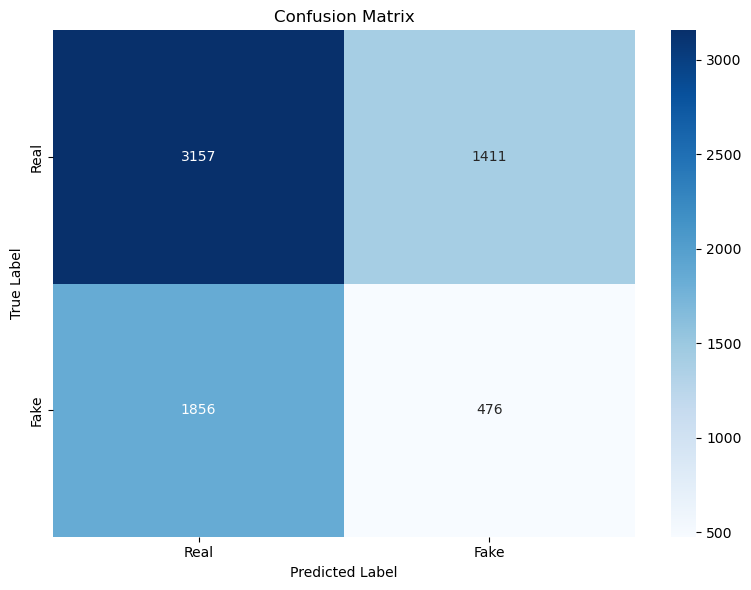

In [19]:
def main():

    print("Starting KNN classification with stylometric features...")

    iteration_num = 1

    # 1. Load and prepare data
    X_train, Y_train, X_test, Y_test, X_eval, Y_eval, _= load_and_prepare_data(iteration_num)
    
    # 2. Training KNN Model
    knn = knn_model(X_train, Y_train)
    
    # 3. Hyperparameter tuning
    best_model, best_params, best_cv_score = hyperparameter_tuning(knn, X_train, Y_train)
    
    # 4. K-fold cross-validation
    cv_scores = k_fold_cross_validation(best_model, X_test, Y_test)
    
    # 5. Final evaluation
    final_results = evaluate_model(best_model, X_eval, Y_eval)
    
    # # 6. Save the best model
    # model_path = f'results/knn_model{iteration_num}_best_weights.pkl'
    # joblib.dump(best_model, model_path)
    # print(f"Best model saved to {model_path}")
    
    # 7. View results
    results_df = pd.DataFrame({
        'Best Parameters': [str(best_params)],
        'Test Accuracy': [final_results['accuracy']],
        'Precision': [final_results['precision']],
        'Recall': [final_results['recall']],
        'F1 Score': [final_results['f1']]
    })
    
    print(results_df)
    print(f"Iteration #{iteration_num} complete!")
    return best_model, final_results

if __name__ == "__main__":
    main()

Starting KNN classification with ALL stylometric features...
Dataset loaded. Shape: (62592, 20)
Train columns: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords']
Eval columns: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords']
Training baseline KNN model...
Performing hyperpa

100%|██████████| 5/5 [00:00<00:00, 18.64it/s]
c:\Users\paulo\miniconda3\envs\AIproj\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


accuracy: 0.7343188174190971
precision: 0.8474320241691843
recall: 0.49866666666666665
Evaluating model on test set...
Test Accuracy: 0.5507
Precision: 0.4997
Recall: 0.5507
F1 Score: 0.5181
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      4568
           1       0.24      0.15      0.18      2332

    accuracy                           0.55      6900
   macro avg       0.43      0.45      0.44      6900
weighted avg       0.50      0.55      0.52      6900

Calculating feature importance...
All features by importance (most to least important):
                                             Feature  Average_Importance
frequency_punctuation          frequency_punctuation            0.666667
avg_sentence_length              avg_sentence_length            0.464882
has_url                                      has_url            0.455234
num_questions                          num_questions            0.442539
percen

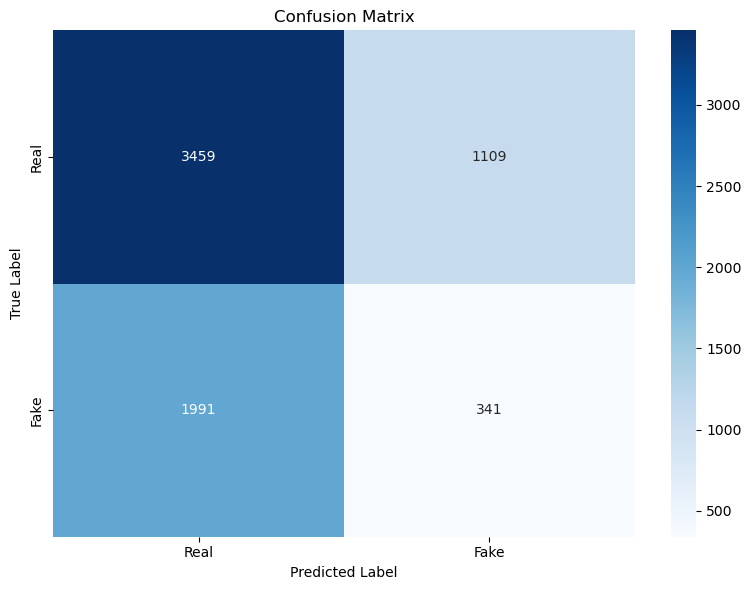

In [20]:
def main():

    print("Starting KNN classification with ALL stylometric features...")

    iteration_num = 2

    # 1. Load and prepare data
    X_train, Y_train, X_test, Y_test, X_eval, Y_eval, feature_columns= load_and_prepare_data(iteration_num)
    
    # 2. Training KNN Model
    knn = knn_model(X_train, Y_train)
    
    # 3. Hyperparameter tuning
    best_model, best_params, best_cv_score = hyperparameter_tuning(knn, X_train, Y_train)
    
    # 4. K-fold cross-validation
    cv_scores = k_fold_cross_validation(best_model, X_test, Y_test)
    
    # 5. Final evaluation
    final_results = evaluate_model(best_model, X_eval, Y_eval)

    feature_importance(best_model, X_train, Y_train, X_test, Y_test, feature_names=feature_columns)
    
    # 7. View results
    results_df = pd.DataFrame({
        'Best Parameters': [str(best_params)],
        'Test Accuracy': [final_results['accuracy']],
        'Precision': [final_results['precision']],
        'Recall': [final_results['recall']],
        'F1 Score': [final_results['f1']]
    })
    
    print(results_df)
    print(f"Iteration #{iteration_num} complete!")
    return best_model, final_results

if __name__ == "__main__":
    main()